# Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Chargement des données

In [38]:
df_full = pd.read_csv("../data/dataset.csv")
df = pd.read_csv("../data/tsfresh_data_cleaned.csv")
df.drop(columns={"Unnamed: 0"}, inplace=True)
outliers_predictions = pd.DataFrame()
outliers_predictions.index = df["index"]

On charge deux datasets: 
    
    
   * le premier "df_full" correspond simplement aux dataset fournis sans traitement. 
   
    
   * Le deuxieme "df", plus complexe, correspond à un jeu de données de features extrait via la librairie tsfresh. Tsfresh est une librairie qui permet d'extraire des milliers de features d'un jeu de données automatiquement. Pour des raisons de lisibilité et de temps de calcul, ce jeu de données a été crée dans le notebook "create Tsfresh" dans le dossier "notebook". Evidemment de nombreux features ne sont pas utiles dans notre cas ou se répetent, nous lnettoyons ce dataset dans la suite.
    

## Netoyage des données

Tout d'abord, on enleve tous les features qui sont trop corrélés entre eux, on considère qu'au dela de 0.9 ils contiennet des informations presque semblables

In [39]:
corr = df.corr()
for col in corr.columns:
    if len(corr[corr[col] >0.9]) > 1:
        temp = corr[corr[col] >0.9]
        to_be_removed = temp.index.tolist()
        to_be_removed.remove(to_be_removed[0])
        try:
            df.drop(columns=to_be_removed, inplace=True)
        except:
            pass

In [40]:
def cycle(x):
    return int(x["day_cycle_window"].split("_")[1])

In [41]:
df_full["cycle"] = df_full.apply(cycle, axis=1)
df_full.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,cycle
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737,1
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472,1
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472,1
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472,1
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237,1


## Exploration de données

<BarContainer object of 2 artists>

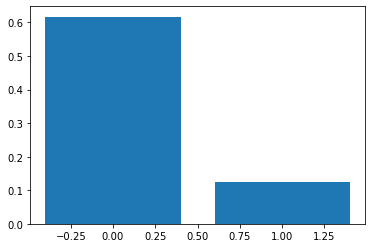

In [54]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(df_full.drop(columns=["cycle","day_cycle_window"]))
variance_ratio = pca.explained_variance_ratio_
df_pca = pd.DataFrame(pca.fit_transform(df_full.drop(columns=["cycle","day_cycle_window"])))
df_pca.insert(loc=0, column="cycle", value=df_full["cycle"])
plt.bar(range(n_components), variance_ratio)

In [55]:
variance_ratio

array([0.61714494, 0.12583446])

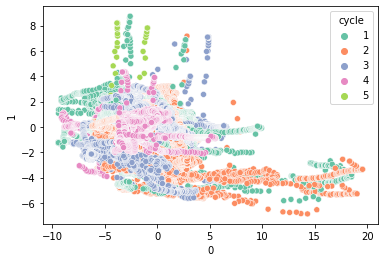

In [56]:
sns.scatterplot(data=df_pca, x=0, y=1, hue="cycle", palette="Set2")
plt.show()

In [57]:
df_pca

,cycle,0,1
0,1,-3.965628,0.237013
1,1,-3.977955,0.246456
2,1,-3.988141,0.301759
3,1,-3.949813,0.374521
4,1,-3.973702,0.556428
...,...,...,...
162697,4,0.626764,-0.856618
162698,4,0.636166,-0.851653
162699,4,0.636817,-0.851291
162700,4,0.654137,-0.850960


In [58]:
def cycle(x):
    return int(x["day_cycle_window"].split("_")[0])

In [59]:
df_full["day"] = df_full.apply(cycle, axis=1)

In [60]:
def cycle(x):
    return int(x["day_cycle_window"].split("_")[2])

In [61]:
df_full["window"] = df_full.apply(cycle, axis=1)

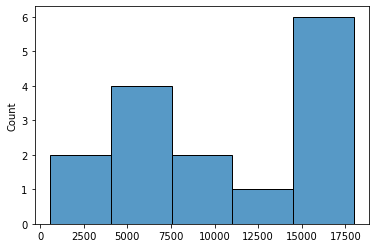

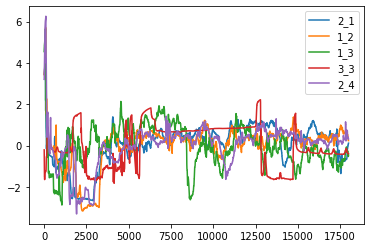

In [62]:
longueur = []
nb_window = []

p1_test = pd.DataFrame()
for idx, ii in enumerate(df_full.day.unique()):
    test = df_full[df_full.day == ii].copy()

    for i in test.cycle.unique():
        temp = pd.DataFrame()
        temp[str(i) + "_" + str(ii)] = test[test.cycle == i]["p2"]
        # print("DAY ", ii, "cycle ", i, "taille ",len(temp),temp[str(i)+"_"+str(ii)].max())
        longueur.append(len(temp))
        nb_window.append(temp[str(i) + "_" + str(ii)].max())
        if len(temp[str(i) + "_" + str(ii)]) > 18000:
            if idx == 0:
                p1_test = pd.concat([p1_test, temp.dropna().reset_index(drop=True)])
            else:
                p1_test = p1_test.join(temp.dropna().reset_index(drop=True))
sns.histplot(longueur)
plt.show()
p1_test.plot()
plt.show()

In [64]:
prob = np.array(longueur).reshape(-1, 1)

In [65]:
longueur

[6775,
 18003,
 553,
 1650,
 9317,
 18002,
 7562,
 14432,
 18003,
 5117,
 18002,
 4885,
 18003,
 6422,
 15976]

In [66]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [67]:
linked = linkage(prob, "ward")

In [68]:
linked

array([[1.00000000e+00, 8.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [5.00000000e+00, 1.00000000e+01, 0.00000000e+00, 2.00000000e+00],
       [1.20000000e+01, 1.50000000e+01, 0.00000000e+00, 3.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.54919334e+00, 5.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 2.32000000e+02, 2.00000000e+00],
       [0.00000000e+00, 1.30000000e+01, 3.53000000e+02, 2.00000000e+00],
       [2.00000000e+00, 3.00000000e+00, 1.09700000e+03, 2.00000000e+00],
       [6.00000000e+00, 2.00000000e+01, 1.11255397e+03, 3.00000000e+00],
       [7.00000000e+00, 1.40000000e+01, 1.54400000e+03, 2.00000000e+00],
       [4.00000000e+00, 2.20000000e+01, 2.93612171e+03, 4.00000000e+00],
       [1.90000000e+01, 2.40000000e+01, 4.11187678e+03, 6.00000000e+00],
       [1.80000000e+01, 2.30000000e+01, 4.73049739e+03, 7.00000000e+00],
       [2.10000000e+01, 2.50000000e+01, 9.66166808e+03, 8.00000000e+00],
       [2.60000000e+01, 2.70000000e+01, 3.25658342e

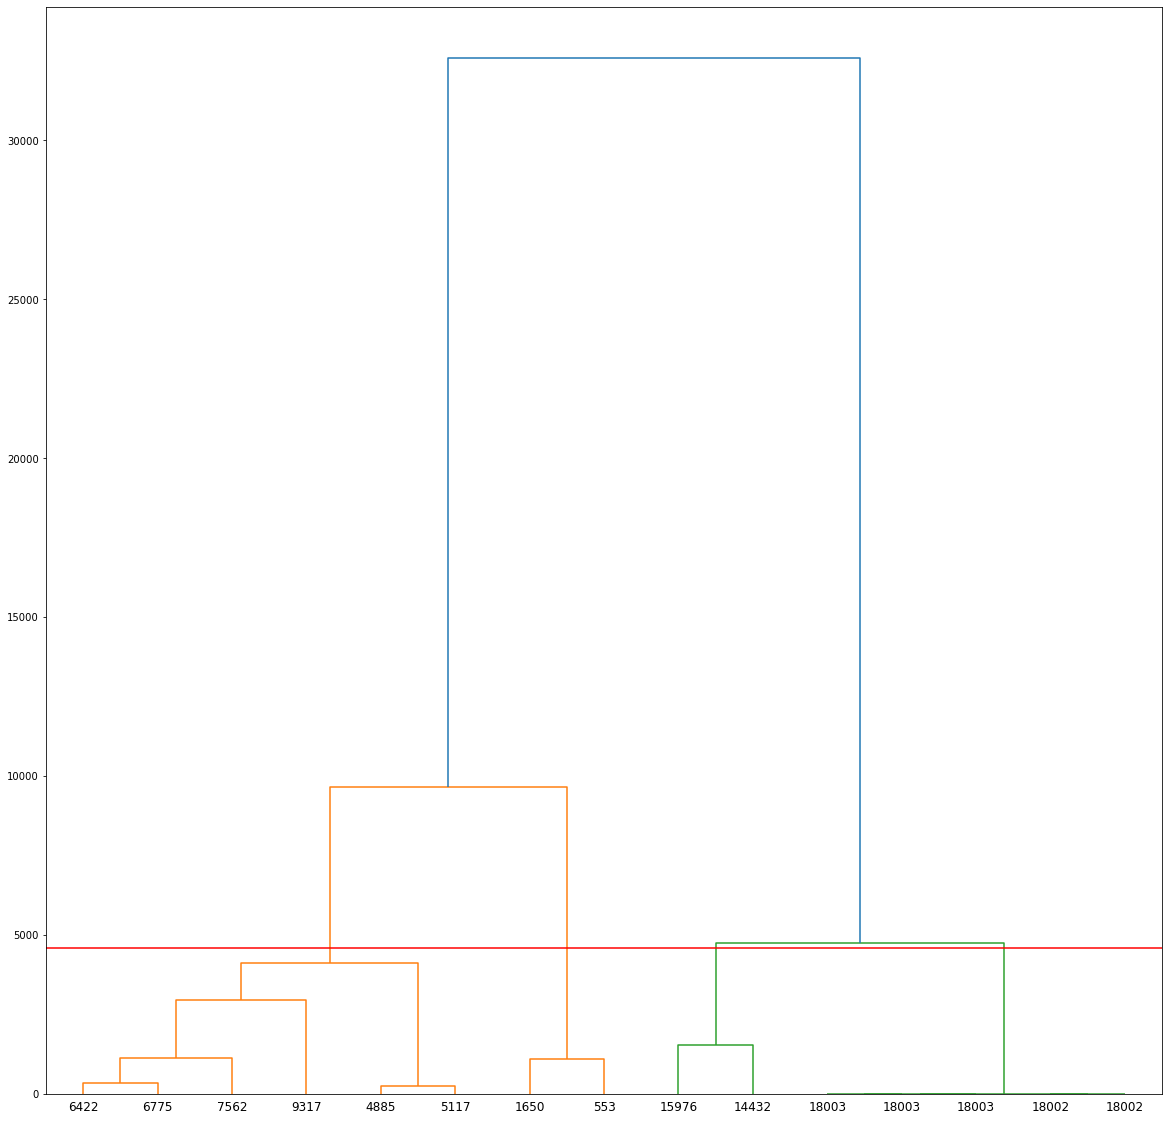

In [69]:
labelList = longueur

plt.figure(figsize=(20, 20))
dendrogram(
    linked,
    orientation="top",
    labels=labelList,
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.axhline(y=4600, color="r", linestyle="-")
plt.show()

In [70]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(
    n_clusters=4, affinity="euclidean", linkage="ward", compute_distances=True
)
classe = cluster.fit_predict(prob)

In [71]:
classe = np.where(
    classe == 0,
    "medium_short",
    np.where(classe == 1, "medium_long", np.where(classe == 2, "short", "long")),
)

In [72]:
def cycle(x):
    return (
        x["day_cycle_window"].split("_")[0] + "_" + x["day_cycle_window"].split("_")[1]
    )


df_full["step"] = df_full.apply(cycle, axis=1)

In [73]:
df_pca["step"]=df_full["step"]

In [74]:
fruits = df_full["step"].unique()

fruit_dictionary = {fruits[idx]: x for idx, x in enumerate(classe)}

In [75]:
def create_class(x):
    return fruit_dictionary[x["step"]]

In [76]:
df_full["classe"] = df_full.apply(create_class, axis=1)

In [77]:
df_pca["classe"]=df_full["classe"]

In [108]:
df_pca["day"]=df_full["day"]

In [96]:
df_pca[df_pca.cycle==ii]

,cycle,0,1,step,classe


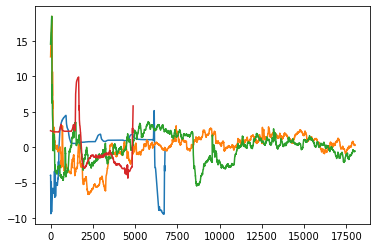

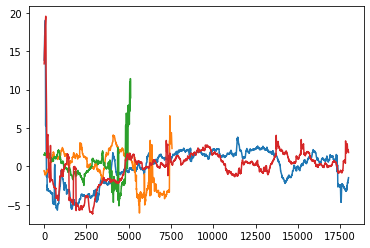

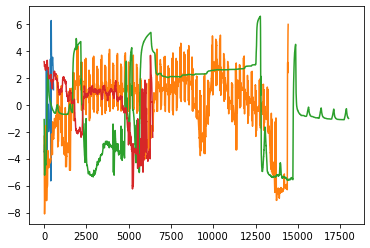

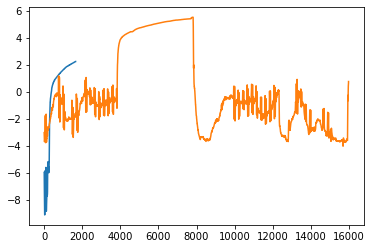

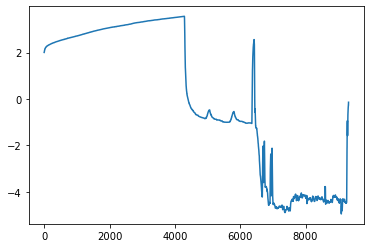

In [134]:
dictio_important = {
    "1": pd.DataFrame(),
    "2": pd.DataFrame(),
    "3": pd.DataFrame(),
    "4": pd.DataFrame(),
    "5": pd.DataFrame(),
}
for idx, ii in enumerate(df_full.cycle.unique()):
    ii=int(ii)
    temp = pd.DataFrame()
    temp_temp= df_pca[df_pca.cycle == ii]
    for i in temp_temp.day.unique():
        plt.plot(temp_temp[temp_temp.day == i][0].reset_index(drop=True))
    plt.show()

In [131]:
for classe in dictio_important.keys():
    dictio_important[classe].plot()

TypeError: no numeric data to plot

On peut remarquer que chaque cycle a un comportement différent que ce soit pour la premiere composante de la pca ou pour la deuxieme composante. Il sera donc interessant de détecter les fenêtres anormales dans chaque cycle

## On concentre le travail par cycle

Nous avons vu dans l'analyse des données que selon le cycle, les comportmemtns n'étaient pas les mêmes, on raisonne donc cycle par cycle


In [31]:
df.set_index("index", drop=True, inplace=True)

In [32]:
dict_df_cycles = {}
dict_df_outliers = {}
dict_df_cycles_full = {}
for i in range(5):
    dict_df_cycles[i] = df[df["cycle"] == (i + 1)]

    outliers_cycle_1 = pd.DataFrame()
    outliers_cycle_1.index = dict_df_cycles[i].index
    dict_df_outliers[i] = outliers_cycle_1

    dict_df_cycles_full[i] = df_full[df_full["cycle"] == (i + 1)].copy()

<AxesSubplot:>

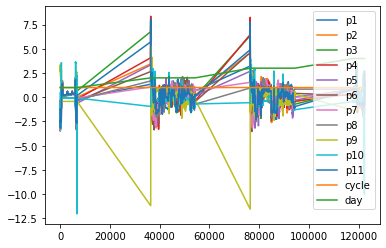

In [33]:
dict_df_cycles_full[0].drop(columns=["window"]).plot()

# IF sur chaque point 

On utilise un algortihtme pour identifier parmis tous les pas de temps ceux qui sont potentiellement anormaux. Onr egroupe ensuite ces observation pour regarder si des windows sortent du lot, pas les données tsfresh ici

In [34]:
def isolation_forest_on_points(df_full_cycle_1, outliers_cycle_1):

    iforest = IsolationForest()
    pred = iforest.fit_predict(df_full_cycle_1.values)
    df_full_cycle_1["mean_scores"] = iforest.decision_function(df_full_cycle_1.values)
    df_full_cycle_1["anomaly_label"] = pred

    print("Anomalies sur les points")
    df_full_cycle_1["anomaly"] = df_full_cycle_1["anomaly_label"].apply(
        lambda x: "outlier" if x == -1 else "inlier"
    )
    fig = sns.histplot(data=df_full_cycle_1, x="mean_scores", hue="anomaly")
    plt.show()
    df_full_cycle_1.drop(columns=["anomaly"], inplace=True)

    df_temp = (
        df_full_cycle_1[["day_cycle_window", "mean_scores"]]
        .groupby("day_cycle_window")
        .mean()[["mean_scores"]]
    )

    print("Anomalies sur les windows, (il faut regarder les scores négatifs)")
    sns.histplot(df_temp["mean_scores"])
    plt.show()

    outliers_cycle_1["RF_on_points"] = np.where(df_temp["mean_scores"] > 0, 0, 1)

In [35]:
for i in range(5):
    print("\n Traitement du cycle numéro", str(i + 1))
    isolation_forest_on_points(dict_df_cycles_full[i], dict_df_outliers[i])


 Traitement du cycle numéro 1


ValueError: could not convert string to float: 'medium_short'

Soit une grosse anomalie soit pleins de potentielles outliers donc que toute la fenetre l'est

# PCA + LOF

Pouruqoi on la fait, je sais pas, trop de variables sans doute ?

On met toutes les avriables entre 0 et 1

In [ ]:
def pca_lof(df_cycle_1, outliers_cycle_1):

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_cycle_1), columns=df_cycle_1.columns
    )

    pca = PCA()
    pca.fit(df_scaled)
    kep = np.sum(1 - (np.cumsum(pca.explained_variance_ratio_) > 0.95))
    print("Nomnbre de variables gardées dans la pca : ", kep)
    pca = PCA(n_components=kep)
    df_pcaed = pd.DataFrame(pca.fit_transform(df_scaled))

    temp = df_pcaed.select_dtypes(exclude=["object"])

    clf = LocalOutlierFactor(n_neighbors=5, contamination=0.15, novelty=True)
    clf.fit(temp.values)

    print(
        "Histogramme des scores donnés par le LOF, les anomalies sont les scores négatids"
    )
    sns.histplot(clf.decision_function(temp.values))
    plt.show()

    outliers_cycle_1["LOF"] = np.where(clf.decision_function(temp.values) > 0, 0, 1)

On décide de garder les variables permettant d'expliquer 95% de la variance, c'est un choix

On applique la PCA

On fait avec PCA, car ça à l'air de donner de meillerus résultats, je sais pas pourquoi, curse of dimensionnality peut être ?

In [ ]:
for i in range(5):
    print("\n Traitement du cycle numéro", str(i + 1))
    pca_lof(dict_df_cycles[i], dict_df_outliers[i])

# Raw data and Isolation Forest

Isolation forest sur les données tsfresh

In [ ]:
def raw_IF(df_cycle_1, outliers_cycle_1):
    df_cycle = df_cycle_1.copy()
    iforest = IsolationForest(random_state=2, max_features=10)
    pred = iforest.fit_predict(df_cycle_1)
    df_cycle["scores"] = iforest.decision_function(df_cycle_1)
    df_cycle["anomaly_label"] = pred

    df_cycle["anomaly"] = df_cycle["anomaly_label"].apply(
        lambda x: "outlier" if x == -1 else "inlier"
    )
    fig = sns.histplot(data=df_cycle, x="scores", hue="anomaly")
    plt.show()
    df_cycle.drop(columns=["anomaly"], inplace=True)

    outliers_cycle_1["RF"] = np.where(df_cycle["scores"] > 0, 0, 1)

In [ ]:
for i in range(5):
    print("\n Traitement du cycle numéro", str(i + 1))
    raw_IF(dict_df_cycles[i], dict_df_outliers[i])

# MAD

Ici truc un peu novateur, on s'intéresse aux écart à la médiane pour chaque variable(plus robuste aux outliers). On normalise ensuite ces écarts sur chaque variable. On somme ensuite ces écarts pour cahque individus. On peut ensuite visualiser sur l'histogramme leur répartition. Nous avons observé qu'une limite entre des potentielles outliers et le groupe central de la distributiuon centré autour de 0 est un écart type. Donc on considère comme outlier tout individus donc la somme des écarts à la médiane centré réduits est supérieur à l'écart type de la distribution

In [ ]:
def mad(df_cycle_1, outliers_cycle_1):
    non_binary = df_cycle_1.apply(lambda x: x.nunique()) > 5
    col_intersting = non_binary[non_binary == True].drop(["window"])
    df_cycle_1_mad = df_cycle_1[col_intersting.index]

    def MAD(col):
        med = col.median()
        mad = (col - med).abs().median()

        anomalies = col - med
        return anomalies.copy()

    mad = df_cycle_1_mad.apply(MAD)
    normalized_mad = (mad - mad.mean()) / mad.std()
    temp = normalized_mad.sum(axis=1)
    anomalie = (
        temp - temp.std()
    )  # Mets la cassure entre anomalies et pas anomalies à zéro

    print("Les anomalies se situent à droite du trait rouge")
    sns.histplot(anomalie)
    plt.axvline(x=0, color="r")
    plt.show()

    outliers_cycle_1["MAD"] = np.where(anomalie < 0, 0, 1)

In [ ]:
for i in range(5):
    print("\n Traitement du cycle numéro", str(i + 1))
    mad(dict_df_cycles[i], dict_df_outliers[i])

# Résultats

In [ ]:
results = pd.concat([dict_df_outliers[i] for i in range(5)])

In [ ]:
windows_anomalies = results[results.sum(axis=1) > 1].index
windows_anomalies

In [ ]:
len(windows_anomalies)

In [ ]:
np.mean(results.sum(axis=1) > 1)

In [ ]:
results

Peutêtre en tracer quelques une qui sont bient des anomalies 

 Possibilité d'autoencoder